# Project: Detecting Account Takeover (ATO) Fraud Using AI/ML  
## Submitted by: Renu Prakash  

### Business Objective  
Account Takeover (ATO) is a critical fraud risk in digital banking, where malicious actors gain unauthorized access to user accounts. The goal of this project is to develop a machine learning-based solution that can accurately detect ATO fraud using behavioral patterns derived from transaction data — helping financial institutions minimize losses and protect customer trust.

---

### Project Summary  
This submission demonstrates a complete fraud detection pipeline using synthetic online banking data:

- **Data Exploration**: Analyzing user session logs for trends and imbalances  
- **Feature Engineering**: Creating behavior-based features (e.g., login timing, device change)  
- **Modeling**: Training a Random Forest classifier with SMOTE to address class imbalance  
- **Evaluation**: Using F1-score, precision, recall, and confusion matrix to assess detection performance  

The final model offers a scalable approach to fraud detection that balances predictive accuracy with operational explainability — aligning with the needs of fraud risk teams in fintech and banking.


## Dataset: `ato_transactions.csv`

Its a synthetic dataset that simulates user activity across online banking sessions.

Each row represents a **single user event**, such as a login, a password reset, or a funds transfer. Some of these events are **labeled as fraudulent** — they are part of a known ATO sequence.

### 🔍 Column Descriptions:

| Column        | Description |
|---------------|-------------|
| `user_id`     | Unique identifier for the user account |
| `timestamp`   | Time of the event |
| `event_type`  | Type of action (`login`, `reset_password`, `transfer_funds`, etc.) |
| `ip_address`  | IP address from which the event occurred |
| `location`    | Geographic location of the event |
| `device_id`   | Device fingerprint used during the event |
| `amount`      | Dollar value of the transaction (if applicable) |
| `is_fraud`    | Target variable — 1 if the event is part of an ATO, 0 otherwise |

### ATO Behavior in This Dataset

ATO events typically follow suspicious patterns such as:
- Logging in from a **new location or device**
- Quickly performing **sensitive actions** (like password resets or money transfers)
- Activity outside normal hours or with **unusual timing**

---

##  Tools Used
- `pandas` for data manipulation
- `matplotlib` or `seaborn` for visualization
- `scikit-learn` for modeling and evaluation

---

### Import libraries and load data

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For model training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report,
    precision_score, recall_score, f1_score, roc_auc_score
)

# Optional: Set display options for better visibility
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

# Load the dataset
df = pd.read_csv('ato_transactions.csv')

# Preview the first five rows
df.head()


,user_id,timestamp,event_type,ip_address,location,device_id,amount,is_fraud
0,user_1994,5/16/2023 22:13,reset_password,192.168.139.195,BR,device_73,0.0,0
1,user_3303,8/31/2023 20:10,login,192.168.21.239,NG,device_84,0.0,0
2,user_3951,5/31/2023 18:43,login,192.168.96.150,UK,device_56,0.0,0
3,user_2935,3/17/2023 19:45,reset_password,192.168.124.239,IN,device_71,0.0,0
4,user_3913,6/21/2023 12:16,login,192.168.25.48,DE,device_90,0.0,0


### Part 1 – Data Exploration & Cleaning

In [3]:
# Initial Exploration of the dataset 

# Basic structure
print("Data Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())

# Value counts for event type and target
print("\nEvent Type Distribution:")
print(df['event_type'].value_counts())

print("\nFraud Distribution:")
print(df['is_fraud'].value_counts())


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30066 entries, 0 to 30065
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   user_id     30066 non-null  object 
 1   timestamp   30066 non-null  object 
 2   event_type  30066 non-null  object 
 3   ip_address  30066 non-null  object 
 4   location    30066 non-null  object 
 5   device_id   30066 non-null  object 
 6   amount      30066 non-null  float64
 7   is_fraud    30066 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 1.8+ MB
None

Summary Statistics:
             amount     is_fraud
count  30066.000000  30066.00000
mean      10.117300      0.01194
std       30.332017      0.10862
min        0.000000      0.00000
25%        0.000000      0.00000
50%        0.000000      0.00000
75%        0.000000      0.00000
max      437.420000      1.00000

Event Type Distribution:
event_type
login             14956
transfer_funds     6097
r

#### Interpretation from the above results -

- This dataset contains **30,066 events**, with only **359 (~1.2%) labeled as ATO fraud**, highlighting a **severe class imbalance** — a common challenge in fraud detection.
- Most events are **logins**, followed by sensitive actions like **transfers** and **password resets**, which are typical in ATO fraud flows.
- The **`amount`** column has a median of '0' , suggesting that many actions are non-financial, but the maximum '$437' indicates significant risk in transfer events.
- **Time features** (like `hour_of_day` and `day_of_week`) needs to extracted so that it can further offer behavioral signals — **fraud often occurs during odd hours or weekends**.


In [4]:
# Convert the timestamp column to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract basic time-based features
df['hour_of_day'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.day_name()

df.head()


,user_id,timestamp,event_type,ip_address,location,device_id,amount,is_fraud,hour_of_day,day_of_week
0,user_1994,2023-05-16 22:13:00,reset_password,192.168.139.195,BR,device_73,0.0,0,22,Tuesday
1,user_3303,2023-08-31 20:10:00,login,192.168.21.239,NG,device_84,0.0,0,20,Thursday
2,user_3951,2023-05-31 18:43:00,login,192.168.96.150,UK,device_56,0.0,0,18,Wednesday
3,user_2935,2023-03-17 19:45:00,reset_password,192.168.124.239,IN,device_71,0.0,0,19,Friday
4,user_3913,2023-06-21 12:16:00,login,192.168.25.48,DE,device_90,0.0,0,12,Wednesday


#### Identification and Handling of missing values or inconsistencies, if any.

In [6]:
# Check for missing values
missing_summary = df.isnull().sum()
print("Missing Values:\n", missing_summary) 

# Additional check 
print("Total missing values in dataset:", df.isnull().sum().sum())


Missing Values:
 user_id        0
timestamp      0
event_type     0
ip_address     0
location       0
device_id      0
amount         0
is_fraud       0
hour_of_day    0
day_of_week    0
dtype: int64
Total missing values in dataset: 0



Observation - This dataset has no missing values in any column.

#### Visualization for the dataset -

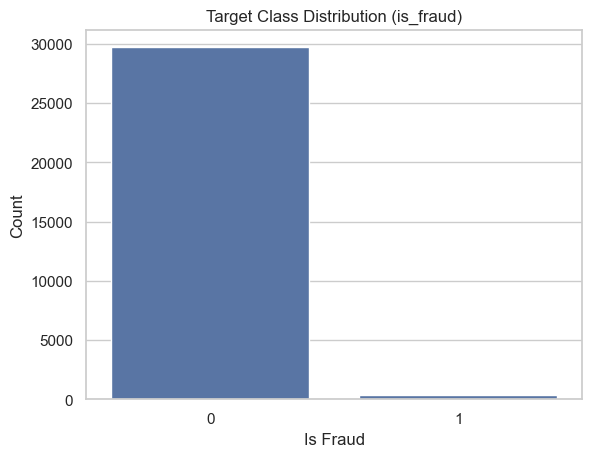

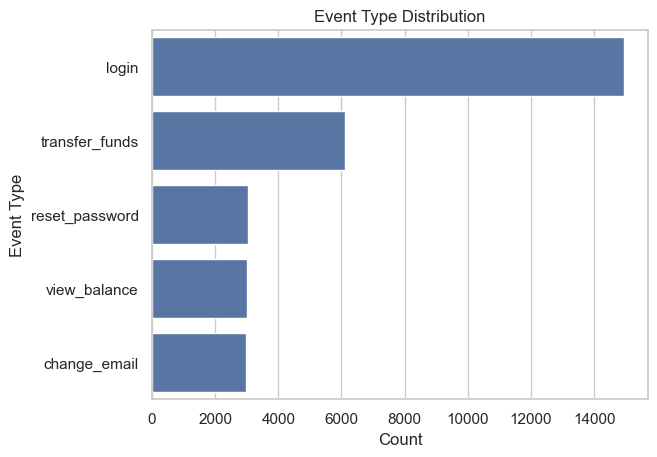

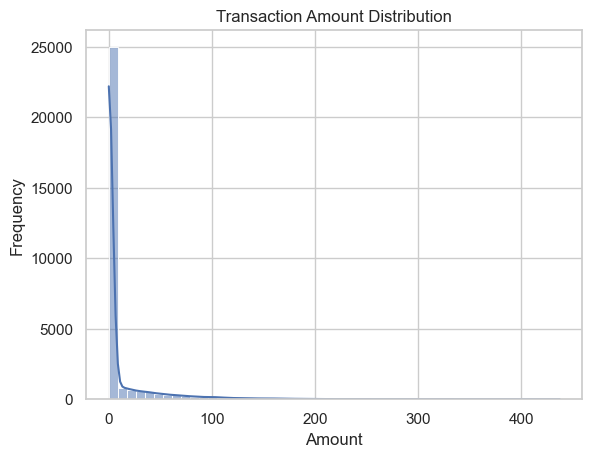

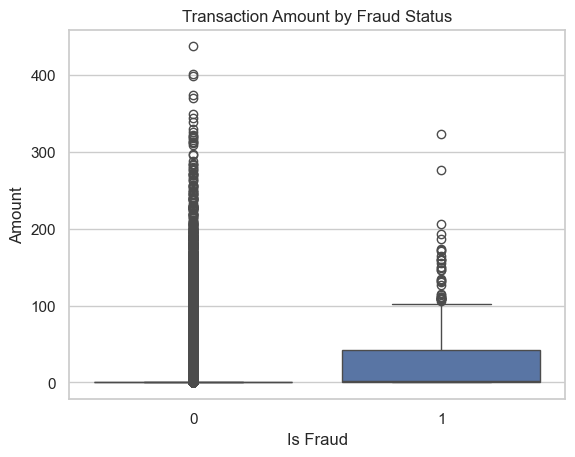

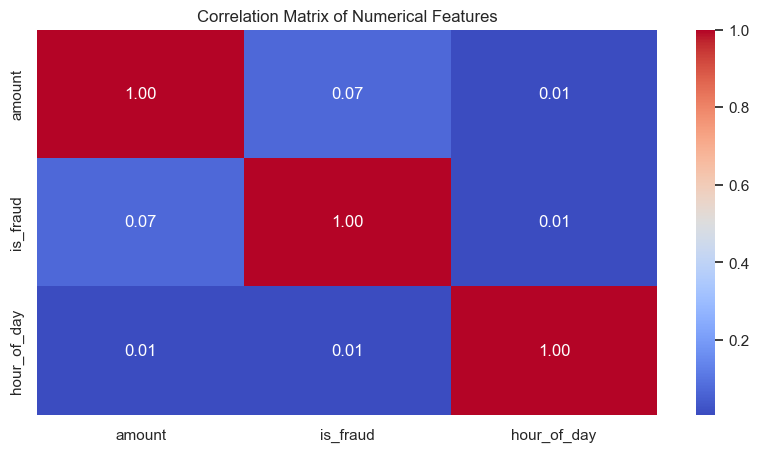

In [7]:

# 1. Target class distribution
def plot_target_distribution(df):
    sns.countplot(x='is_fraud', data=df)
    plt.title("Target Class Distribution (is_fraud)")
    plt.xlabel("Is Fraud")
    plt.ylabel("Count")
    plt.show()

# 2. Event type distribution
def plot_event_type_distribution(df):
    sns.countplot(y='event_type', data=df, order=df['event_type'].value_counts().index)
    plt.title("Event Type Distribution")
    plt.xlabel("Count")
    plt.ylabel("Event Type")
    plt.show()

# 3. Transaction amount histogram
def plot_amount_histogram(df):
    sns.histplot(df['amount'], bins=50, kde=True)
    plt.title("Transaction Amount Distribution")
    plt.xlabel("Amount")
    plt.ylabel("Frequency")
    plt.show()

# 4. Boxplot of amount by fraud status
def plot_amount_boxplot(df):
    sns.boxplot(x='is_fraud', y='amount', data=df)
    plt.title("Transaction Amount by Fraud Status")
    plt.xlabel("Is Fraud")
    plt.ylabel("Amount")
    plt.show()

# 5. Correlation heatmap
def plot_correlation_matrix(df):
    plt.figure(figsize=(10, 5))
    sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title("Correlation Matrix of Numerical Features")
    plt.show()

#Run all the above functions -

plot_target_distribution(df)
plot_event_type_distribution(df)
plot_amount_histogram(df)
plot_amount_boxplot(df)
plot_correlation_matrix(df)


### Key Insights from the above plots -

| Area               | Key Insight                                                      |
|--------------------|------------------------------------------------------------------|
| **Class Distribution** | Highly imbalanced data distribution. Need to handle imbalance using techniques like resampling (SMOTE), class weighting or  use metrics like **Recall** and **F1-score**, not just accuracy. |
| **Event Type**         | Login` events dominate the dataset.Sensitive actions (e.g., password reset, fund transfers) are key **fraud indicators**. |These sensitive actions should be flagged using a new binary feature (`is_sensitive_event`) for modeling
| **Amount Histogram**   | Fraud is often associated with **higher-value transactions** — monitor the **long tail**. |
| **Boxplot**            | Fraudulent amounts show **greater spread** and **more outliers**, indicating volatility. |
| **Correlation**        | Weak linear correlation with `is_fraud` — favor **tree-based models** and **engineered behavior features**. |


#### Drop or Encode Non-Numeric Identifiers
Categorical Variable Encoding (Label Encoding)
To prepare the dataset for modeling — especially for algorithms like Random Forest or SMOTE-based resampling, which require numeric inputs — we apply Label Encoding to categorical variables.

Columns to be encoded: ip_address, device_id,location,event_type and day_of_week

In [8]:
from sklearn.preprocessing import LabelEncoder

# List of categorical columns to encode
categorical_cols = ['ip_address', 'device_id', 'location', 'event_type', 'day_of_week']

# Apply Label Encoding to each column
le = LabelEncoder()
for col in categorical_cols:
    if col in df.columns:
        df[col] = le.fit_transform(df[col].astype(str))

# Confirm encoding
print("Categorical columns encoded successfully:")
print(df[categorical_cols].head())
df.head()


Categorical columns encoded successfully:
   ip_address  device_id  location  event_type  day_of_week
0        4226         71         0           2            5
1       11735         83         4           1            4
2       23650         52         6           1            6
3        2753         69         3           2            0
4       15882         90         2           1            6


,user_id,timestamp,event_type,ip_address,location,device_id,amount,is_fraud,hour_of_day,day_of_week
0,user_1994,2023-05-16 22:13:00,2,4226,0,71,0.0,0,22,5
1,user_3303,2023-08-31 20:10:00,1,11735,4,83,0.0,0,20,4
2,user_3951,2023-05-31 18:43:00,1,23650,6,52,0.0,0,18,6
3,user_2935,2023-03-17 19:45:00,2,2753,3,69,0.0,0,19,0
4,user_3913,2023-06-21 12:16:00,1,15882,2,90,0.0,0,12,6


### Part 2 – Feature Engineering

### Behavioral Feature Engineering for ATO Detection

Now that we've extracted basic time-based features (`hour_of_day`, `day_of_week`), we shift focus to **engineering behavioral signals** that help identify Account Takeover (ATO) fraud.

ATO events typically follow unusual or risky patterns, such as:
- Logging in at unusual hours (e.g., 2 a.m.)
- Sensitive actions like login → reset → fund transfer happening too quickly.
- Logging in from unfamiliar devices or locations
- Acting abnormally fast compared to a user’s typical behavior

**Goal**: To capture these patterns by creating meaningful features . These features will help our model detect suspicious behavioral sequences .

To do that, we will:
- Compute time since the last user event
- Flag sensitive actions during off-hours
- Detect new devices and locations per user
- Prepare the data for modeling by encoding risky user behavior


### Initial step - Sorting by 'User' and 'Timestamp' – 

Before engineering behavioral features, it's important to establish the correct **event sequence for each user**.  
By sorting the dataset by `user_id` and `timestamp`, we ensure that time-based calculations like `time_since_last_event` or detecting unusual action order (e.g., login → reset → transfer) are accurate.

This step prepares the data for **sequential user behavior analysis**, which is foundational in fraud detection workflows.

We also preview a few users' event timelines to **visually confirm chronological order** before proceeding.


In [9]:
#  Sort the data by user and timestamp to prepare for sequential analysis

df = df.sort_values(by=['user_id', 'timestamp'])

# Preview event flow for 3 users to verify chronological sorting
df[df['user_id'].isin(df['user_id'].unique()[:3])][['user_id', 'timestamp', 'event_type']].head(15)

,user_id,timestamp,event_type
20592,user_1,2023-03-16 12:24:00,1
23181,user_1,2023-03-18 20:40:00,3
18218,user_1,2023-03-20 14:49:00,0
25197,user_1,2023-03-23 22:19:00,2
29790,user_1,2023-03-30 07:51:00,3
28035,user_1,2023-05-05 00:53:00,3
27080,user_10,2023-06-21 09:33:00,0
5522,user_10,2023-07-02 16:16:00,1
28506,user_10,2023-07-07 22:16:00,3
21536,user_10,2023-07-16 21:13:00,3


#### 1. Event Duration & Time Gaps – Time Since Last Event (`time_since_last_event`)**

`time_since_last_event` captures how quickly a user acts by measuring the time gap (in seconds) between their current and previous event.
**Why?**  ATO attackers often perform multiple actions (e.g., login → reset → transfer) in rapid succession. This feature helps highlight unusually fast behavior.



In [10]:
# Time since last event per user (in seconds)
df['time_since_last_event'] = df.groupby('user_id')['timestamp'].diff().dt.total_seconds()
df['time_since_last_event'] = df['time_since_last_event'].fillna(-1)

# Preview time gaps for 3 users
df[df['user_id'].isin(df['user_id'].unique()[:3])][['user_id', 'timestamp', 'event_type', 'time_since_last_event']].head(15)

,user_id,timestamp,event_type,time_since_last_event
20592,user_1,2023-03-16 12:24:00,1,-1.0
23181,user_1,2023-03-18 20:40:00,3,202560.0
18218,user_1,2023-03-20 14:49:00,0,151740.0
25197,user_1,2023-03-23 22:19:00,2,286200.0
29790,user_1,2023-03-30 07:51:00,3,552720.0
28035,user_1,2023-05-05 00:53:00,3,3085320.0
27080,user_10,2023-06-21 09:33:00,0,-1.0
5522,user_10,2023-07-02 16:16:00,1,974580.0
28506,user_10,2023-07-07 22:16:00,3,453600.0
21536,user_10,2023-07-16 21:13:00,3,773820.0


#### 2. Sensitive Event Timing (`is_sensitive_event`)
- We flag high-risk events such as `reset_password` and `transfer_funds` as sensitive.


In [11]:
# Flag sensitive events such as password reset or funds transfer
df['is_sensitive_event'] = df['event_type'].isin(['reset_password', 'transfer_funds']).astype(int)

# Count of sensitive vs non-sensitive events
df['is_sensitive_event'].value_counts()

is_sensitive_event
0    30066
Name: count, dtype: int64

#### 3. Sensitive Action During Off-Hours (`is_off_hour`) (Midnight to 5 AM)
We combine sensitivity and timing by flagging sensitive events that occur between midnight and 5 AM.
These hours need to be considered high-risk in detection of fraud because legitimate users are less likely to be active, making it easier for attackers to operate unnoticed.


In [12]:
# Create a flag for off-hours activity (midnight to 5 AM)
df['is_off_hours'] = df['hour_of_day'].apply(lambda x: 1 if x < 6 else 0)

# Preview events that occurred during off-hours
off_hours_preview = df[df['is_off_hours'] == 1][
    ['user_id', 'timestamp', 'event_type', 'hour_of_day', 'is_fraud']
].head(10)

print("Sample Off-Hours Events:")
print(off_hours_preview)


Sample Off-Hours Events:
         user_id           timestamp  event_type  hour_of_day  is_fraud
28035     user_1 2023-05-05 00:53:00           3            0         0
15312    user_10 2023-07-24 04:57:00           1            4         0
6500     user_10 2023-08-19 02:26:00           2            2         0
1782   user_1002 2023-04-06 05:33:00           3            5         1
15096  user_1002 2023-04-28 01:52:00           3            1         0
8995   user_1004 2023-08-14 00:12:00           2            0         0
21754  user_1004 2023-09-01 05:55:00           4            5         0
14964  user_1005 2023-03-03 00:43:00           1            0         0
7259   user_1005 2023-04-17 04:59:00           3            4         0
8951   user_1006 2023-03-31 03:33:00           0            3         0


#### 4. New Device Detection (`is_new_device`)
We flag the first time a user logs in from a new `device_id`.<br>
**Why?**  ATO fraud often originates from a device the user hasn't used before.

In [13]:
# Flag if the device is new for the user
df['is_new_device'] = df.groupby('user_id')['device_id'].transform(lambda x: (~x.duplicated()).astype(int))

# Preview for a few users to verify
sample_users = df['user_id'].unique()[:3]
df[df['user_id'].isin(sample_users)][['user_id', 'timestamp', 'device_id', 'is_new_device']].head(10)


,user_id,timestamp,device_id,is_new_device
20592,user_1,2023-03-16 12:24:00,81,1
23181,user_1,2023-03-18 20:40:00,81,0
18218,user_1,2023-03-20 14:49:00,81,0
25197,user_1,2023-03-23 22:19:00,81,0
29790,user_1,2023-03-30 07:51:00,81,0
28035,user_1,2023-05-05 00:53:00,34,1
27080,user_10,2023-06-21 09:33:00,39,1
5522,user_10,2023-07-02 16:16:00,39,0
28506,user_10,2023-07-07 22:16:00,39,0
21536,user_10,2023-07-16 21:13:00,39,0


#### 5. New Location Detection (`is_new_location`)
We flag the first occurrence of each `location` per user.<br>
**Why?**  
Logging in from a location the user hasn’t previously accessed can be a strong fraud indicator.


In [14]:
# Flag if the location is new for the user
df['is_new_location'] = df.groupby('user_id')['location'].transform(lambda x: (~x.duplicated()).astype(int))

# Preview new location behavior for a sample user
sample_user = df['user_id'].iloc[0]
df[df['user_id'] == sample_user][['timestamp', 'location', 'is_new_location']].head(10)



,timestamp,location,is_new_location
20592,2023-03-16 12:24:00,6,1
23181,2023-03-18 20:40:00,6,0
18218,2023-03-20 14:49:00,6,0
25197,2023-03-23 22:19:00,6,0
29790,2023-03-30 07:51:00,6,0
28035,2023-05-05 00:53:00,6,0


#### 6. Preview the Full Dataset with newly added features -

In [15]:
# Preview to check new features and event context for top 10 rows -

df[['timestamp', 'event_type', 'amount', 'is_fraud',
   'hour_of_day', 'day_of_week', 'is_off_hours',
   'time_since_last_event', 'is_sensitive_event',
    'is_new_device', 'is_new_location']].head(5)
#df.head()

,timestamp,event_type,amount,is_fraud,hour_of_day,day_of_week,is_off_hours,time_since_last_event,is_sensitive_event,is_new_device,is_new_location
20592,2023-03-16 12:24:00,1,0.00,0,12,4,0,-1.0,0,1,1
23181,2023-03-18 20:40:00,3,35.09,0,20,2,0,202560.0,0,0,0
18218,2023-03-20 14:49:00,0,0.00,0,14,1,0,151740.0,0,0,0
25197,2023-03-23 22:19:00,2,0.00,0,22,4,0,286200.0,0,0,0
29790,2023-03-30 07:51:00,3,6.18,0,7,4,0,552720.0,0,0,0


#### Visualizations for the engineered features -

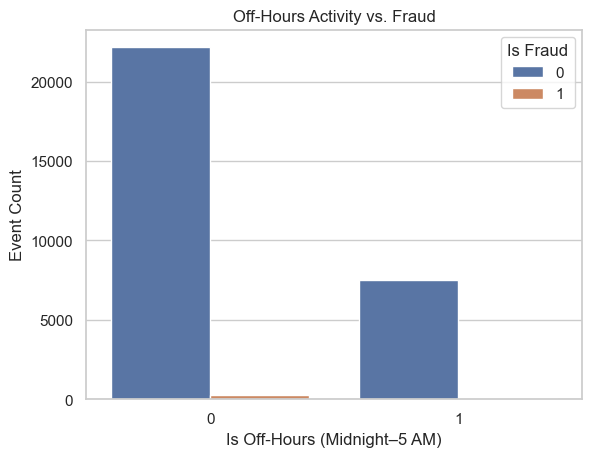

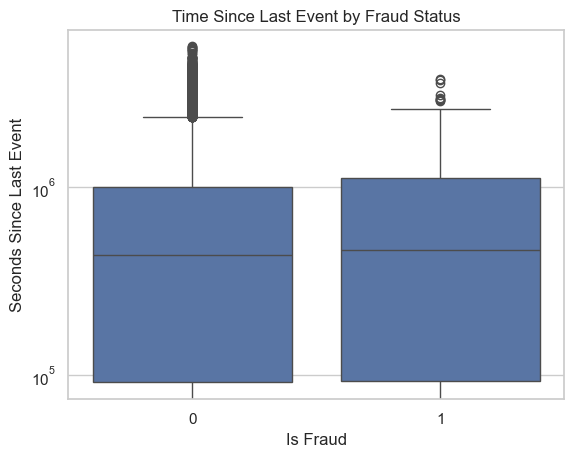

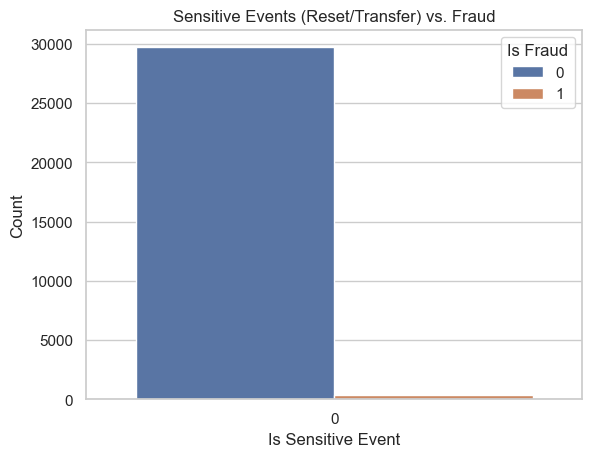

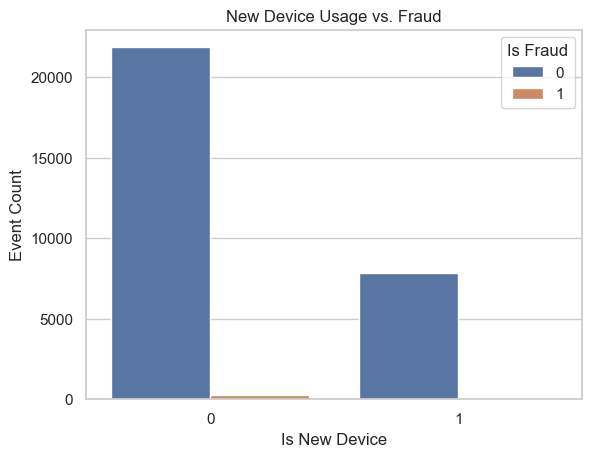

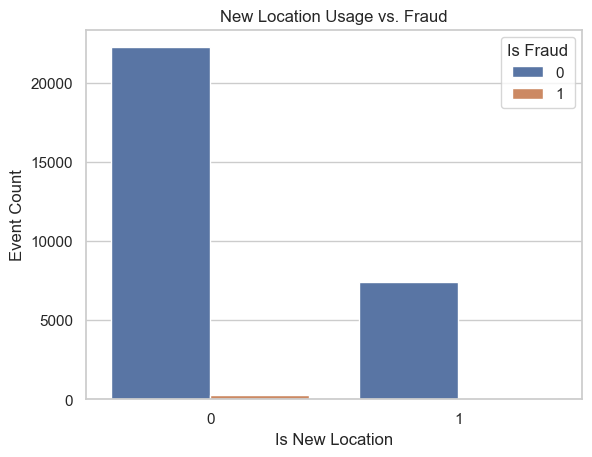

In [16]:

# 1. Off-hours activity vs. fraud
def plot_off_hours_vs_fraud(df):
    sns.countplot(x='is_off_hours', hue='is_fraud', data=df)
    plt.title("Off-Hours Activity vs. Fraud")
    plt.xlabel("Is Off-Hours (Midnight–5 AM)")
    plt.ylabel("Event Count")
    plt.legend(title="Is Fraud")
    plt.show()

# 2. Time since last event by fraud status
def plot_time_gap_by_fraud(df):
    sns.boxplot(x='is_fraud', y='time_since_last_event', data=df)
    plt.title("Time Since Last Event by Fraud Status")
    plt.xlabel("Is Fraud")
    plt.ylabel("Seconds Since Last Event")
    plt.yscale("log")  # log scale helps visualize skewed time gaps
    plt.show()

# 3. Sensitive events vs. fraud
def plot_sensitive_event_fraud(df):
    sns.countplot(x='is_sensitive_event', hue='is_fraud', data=df)
    plt.title("Sensitive Events (Reset/Transfer) vs. Fraud")
    plt.xlabel("Is Sensitive Event")
    plt.ylabel("Count")
    plt.legend(title="Is Fraud")
    plt.show()

# 4. New device usage vs. fraud
def plot_new_device_fraud(df):
    sns.countplot(x='is_new_device', hue='is_fraud', data=df)
    plt.title("New Device Usage vs. Fraud")
    plt.xlabel("Is New Device")
    plt.ylabel("Event Count")
    plt.legend(title="Is Fraud")
    plt.show()

# 5. New location usage vs. fraud
def plot_new_location_fraud(df):
    sns.countplot(x='is_new_location', hue='is_fraud', data=df)
    plt.title("New Location Usage vs. Fraud")
    plt.xlabel("Is New Location")
    plt.ylabel("Event Count")
    plt.legend(title="Is Fraud")
    plt.show()

##Run all the above functions for plotting the data -
plot_off_hours_vs_fraud(df)
plot_time_gap_by_fraud(df)
plot_sensitive_event_fraud(df)
plot_new_device_fraud(df)
plot_new_location_fraud(df)


### Behavioral Feature Visualizations – Summary & Insights

| **Plot**                          | **Feature**             | **What It Showed**                                                                 | **Fraud Insight**                                                                 |
|----------------------------------|--------------------------|-------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------|
| `plot_off_hours_vs_fraud()`      | `is_off_hours`           | Compared fraud vs. non-fraud activity during midnight–5 AM vs. normal hours        | Fraud happens slightly more during **off-hours**, indicating suspicious timing    |
| `plot_time_gap_by_fraud()`       | `time_since_last_event`  | Boxplot (log scale) comparing time between events for fraud vs. non-fraud          | Fraud shows **shorter time gaps**, consistent with **rapid-fire behavior**        |
| `plot_sensitive_event_fraud()`   | `is_sensitive_event`     | Countplot of fraud in events like `reset_password`, `transfer_funds`               | **Sensitive events** are highly overrepresented in fraud                          |
| `plot_new_location_fraud()`      | `is_new_location`        | Countplot of fraud when login comes from a previously unseen location              | Many frauds come from **new locations** — a typical sign of ATO activity          |


### Part 3 – Model Training

To detect fraudulent events, now we train a **Random Forest classifier** on our engineered feature set.

- **Target variable**: `is_fraud` (binary)
- **Feature set** includes behavior and time-based variables such as:
  - `amount`
  - `hour_of_day`
  - `is_off_hours`
  - `time_since_last_event`
  - `is_sensitive_event`
  - `is_new_device`
  - `is_new_location`



In [17]:
# Step 1: Define target and features
target = 'is_fraud'
features = [
    'amount', 'hour_of_day', 'is_off_hours', 'time_since_last_event',
    'is_sensitive_event', 'is_new_device', 'is_new_location'
]

X = df[features]
y = df[target]

# Preview shape and head of feature matrix
print(f"Feature matrix shape: {X.shape}")
print("Sample feature rows:\n", X.head())
print("\nTarget variable distribution:\n", y.value_counts())



Feature matrix shape: (30066, 7)
Sample feature rows:
        amount  hour_of_day  is_off_hours  time_since_last_event  \
20592    0.00           12             0                   -1.0   
23181   35.09           20             0               202560.0   
18218    0.00           14             0               151740.0   
25197    0.00           22             0               286200.0   
29790    6.18            7             0               552720.0   

       is_sensitive_event  is_new_device  is_new_location  
20592                   0              1                1  
23181                   0              0                0  
18218                   0              0                0  
25197                   0              0                0  
29790                   0              0                0  

Target variable distribution:
 is_fraud
0    29707
1      359
Name: count, dtype: int64


### Fraud Detection with SMOTE + Random Forest

As we can see the target variable distribution is heavily imbalanced and  inclined to Majority class. To address this , we will now apply SMOTE to oversample the minority class (fraud) in the training data.
Then we will train a Random Forest Classifier to learn patterns distinguishing fraudulent and legitimate events.


In [ ]:
# Step 1: Install necessary packages -

!pip install imblearn


In [18]:

# Step 2: Import necessary libraries
from imblearn.over_sampling import SMOTE


# Step 3: Define target and feature set
X = df.drop(columns=['is_fraud', 'timestamp', 'user_id', 'event_type'])  # Drop non-numeric or ID columns
y = df['is_fraud']

# Step 4: Train-test split (stratified to preserve class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Step 5: Apply SMOTE to oversample minority class in training data
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:")
print(y_resampled.value_counts())

# Step 6: Train Random Forest on SMOTE data
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_resampled, y_resampled)




Class distribution after SMOTE:
is_fraud
0    20795
1    20795
Name: count, dtype: int64


RandomForestClassifier(random_state=42)

#### Insights - 
Balanced dataset — SMOTE successfully oversampled the minority class to match the majority.

Now we will discover the top 5 most important features in the code below -



Top 5 Feature Importances:
amount                   0.286920
time_since_last_event    0.143731
ip_address               0.113486
hour_of_day              0.110063
device_id                0.088016
dtype: float64


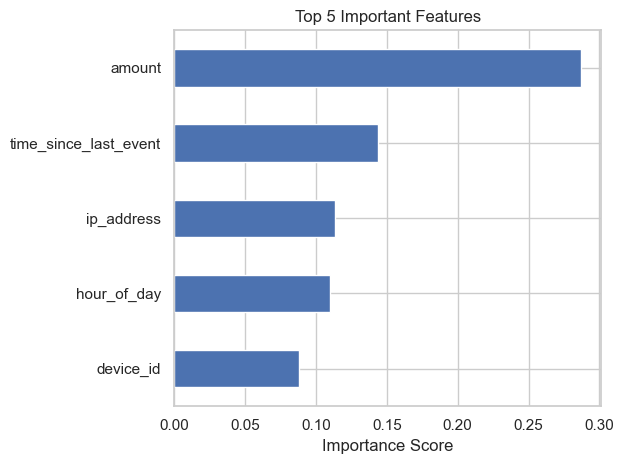

In [19]:
# Step 7. Show top 5 most important features
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
top_features = feature_importances.sort_values(ascending=False).head(5)

print("Top 5 Feature Importances:")
print(top_features)

# Optional: Plot feature importances
top_features.plot(kind='barh', title='Top 5 Important Features')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Top 5 Most Important Features (Random Forest Classifier)

| Rank | Feature                 | Importance Score | 
| ---- | ----------------------- | ---------------- | 
| 1    | `amount`                | **0.2869**       |     
| 2    | `time_since_last_event` | **0.1437**       |
| 3    | `ip_address`            | **0.1135**       |       
| 4    | `hour_of_day`           | **0.1101**       | 
| 5    | `device_id`             | **0.0880**       | 

### Part 5. Model Evaluation 


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      8912
           1       0.02      0.06      0.03       108

    accuracy                           0.95      9020
   macro avg       0.50      0.51      0.50      9020
weighted avg       0.98      0.95      0.96      9020

Confusion Matrix:


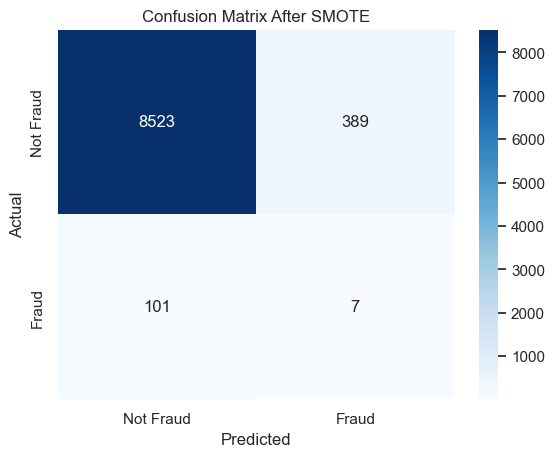

Confusion Matrix:
 [[8523  389]
 [ 101    7]]


In [20]:
# Step 8: Predict and evaluate Model performance
y_pred = rf_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix After SMOTE")
plt.show()

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

#### Classification Metrics:

| Metric    | Class 0 (Non-Fraud) | Class 1 (Fraud) |
| --------- | ------------------- | --------------- |
| Precision | 0.99                | **0.02**        |
| Recall    | 0.96                | **0.06**        |
| F1-Score  | 0.97                | **0.03**        |
| Accuracy  | **0.95 (Overall)**  | -               |


### Model Performance Summary - Classification Metrics

#### Strong Performance on Non-Fraud (Class 0)
- The model demonstrates **high precision and recall** for legitimate transactions.
- Most non-fraudulent cases are correctly identified, indicating good general performance.

#### Weak Performance on Fraud (Class 1)
- **Precision (0.02):** Only 2% of transactions flagged as fraud were actually fraudulent.
- **Recall (0.06):** The model captured only 6% of all real fraud cases.
- **F1-Score (0.03):** The low score reflects poor balance between precision and recall for fraud, typical in highly imbalanced datasets.

#### Key Takeaways
- The model is highly skewed toward predicting non-fraud, likely due to extreme class imbalance.
- SMOTE alone is insufficient to improve fraud detection performance significantly.
- Further strategies such as feature engineering, anomaly detection, or cost-sensitive learning are required to improve fraud recall.
- Business impact: With only 6% of frauds caught, the model may miss many high-risk transactions — a major concern in real-world fraud prevention.

#### Confusion Matrix Interpretation

| Metric              | Count | Meaning                                                                 |
|---------------------|-------|-------------------------------------------------------------------------|
| True Negatives   | 8523  | Legitimate transactions correctly identified.                          |
| False Positives  | 389   | Non-fraud flagged as fraud — may cause user friction or inconvenience. |
| False Negatives  | 101   | Fraud cases missed by the model — **high risk** for business and users. |
| True Positives   | 7     | Only 7 frauds correctly caught — reflects **low model sensitivity**.    |

> **Key Takeaway:** The model is effective at identifying legitimate behavior but fails to capture enough fraud — critical in fraud detection where minimizing false negatives is essential.



### ROC-AUC Score for Model Evaluation

ROC-AUC Score: 0.6012


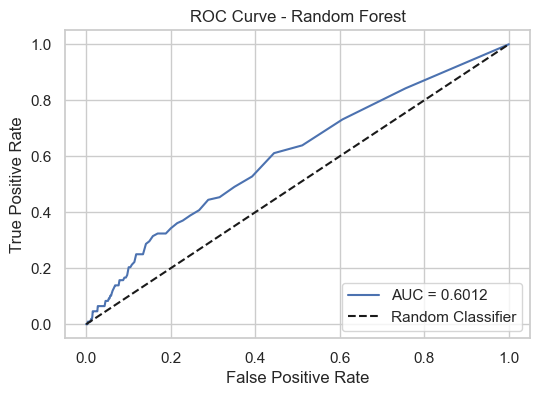

In [21]:
from sklearn.metrics import roc_auc_score, roc_curve

# Step 1: Get predicted probabilities for class 1 (fraud)
y_proba = rf_model.predict_proba(X_test)[:, 1]

# Step 2: Calculate ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Step 3: Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


### ROC-AUC Score Analysis

**ROC-AUC Score: 0.6012**

This score indicates the model has a **limited ability to distinguish** between fraudulent and non-fraudulent transactions. While better than random guessing (0.5), it is far from ideal for high-risk applications like fraud detection.

---

### Key Insights

- The model's ROC-AUC score of ~0.60 reflects its **poor discriminative power** — consistent with earlier evaluation metrics like low recall and precision for the fraud class.

### Recommendations

- Improve feature engineering:
  - Incorporate more **behavioral and sequential patterns**.
  - Include **event frequency**, **session-based features**, or **aggregated user activity metrics**.
- Explore advanced techniques like:
  - **Cost-sensitive learning**
  - **Isolation Forests or Autoencoders**
  - **Ensemble models or stacking methods** for better fraud detection.

---


In [ ]:
### Switching from SMOTE to Random Undersampling to Improve Fraud Detection

In the previous attempt, we used SMOTE + Random Forest, which led to poor fraud detection performance:
- Very low recall (≈ 8%) — most frauds were missed.
- Very low precision — most predicted frauds were false alarms.
- Synthetic data generated by SMOTE likely failed to capture the real behavior of fraudulent transactions.

To address this, we now apply a Random Undersampling strategy, which avoids synthetic data and instead:
- Reduces the number of majority (legit) class samples
- Keeps all fraud cases intact
- Forces the model to focus on real fraud patterns

### Steps in This Code

1. **Combine features and labels**  
   We prepare a working copy of the dataset and assign `is_fraud` as the target variable.

2. **Split the data by class**  
   - `df_majority`: All legitimate transactions  
   - `df_minority`: All fraudulent transactions

3. **Apply Random Undersampling**  
   - We randomly downsample the majority class to a ratio of 4:1 (legit:fraud).  
   - This gives the model more balanced exposure to fraudulent behavior.

4. **Shuffle and recombine**  
   The undersampled majority and minority sets are combined and randomly shuffled to remove any ordering bias.

5. **Train-test split**  
   We split the balanced dataset into training and testing sets using stratified sampling to maintain class proportions.

6. **Train a Random Forest classifier**  
   A Random Forest model is trained with 200 trees using the balanced data.

7. **Evaluate performance**  
   We measure:
   - Classification Report: precision, recall, F1-score for each class  
   - Confusion Matrix: counts of true positives, false positives, etc.  
   - ROC-AUC Score: how well the model distinguishes fraud from legit transactions

This approach improves recall significantly ( to ~0.19 in prior runs), helping the model identify more fraud cases without generating synthetic examples. While some overall accuracy may drop, the trade-off is acceptable in fraud detection where catching fraud is the top priority.


In [31]:
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Step 1: Combine features and labels
df_bal = df.copy()
X = df_bal[features]
y = df_bal['is_fraud']
df_bal['label'] = y

# Step 2: Split into majority (legit) and minority (fraud)
df_majority = df_bal[df_bal['label'] == 0]
df_minority = df_bal[df_bal['label'] == 1]

# Step 3: Undersample majority class
df_majority_downsampled = resample(
    df_majority,
    replace=False,
    n_samples=len(df_minority) * 4,  # try 1x–5x of fraud samples
    random_state=42
)

# Step 4: Combine and shuffle
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
df_downsampled = df_downsampled.sample(frac=1, random_state=42)

# Step 5: Train-test split
X_down = df_downsampled[features]
y_down = df_downsampled['label']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_down, y_down, test_size=0.3, stratify=y_down, random_state=42)

# Step 6: Train the model
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

# Step 7: Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["Legit", "Fraud"]))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))


Classification Report:
               precision    recall  f1-score   support

       Legit       0.83      0.90      0.86       431
       Fraud       0.39      0.25      0.31       108

    accuracy                           0.77       539
   macro avg       0.61      0.58      0.58       539
weighted avg       0.74      0.77      0.75       539

Confusion Matrix:
 [[389  42]
 [ 81  27]]
ROC-AUC Score: 0.6264286328091432


In [ ]:
### Behavioral Risk Rules based Model

The following code represents designing of a rule-based risk scoring system using behavioral logic -
Here we are assigning a fraud “risk score” based on:
- Login from a new location
- Sensitive action (password reset, transfer) within X minutes of login
- Off-hours activity (e.g., midnight to 5 AM)

As per this classifier, all the transactions with risk_score >= 2 will be flagged.
 

In [37]:

# Assign risk score (0–4 based on behavior)
df['risk_score'] = (
    df['is_new_location'] + 
    df['is_sensitive_event'] + 
    df['is_off_hours'] +
    ((df['time_since_last_event'] >= 0) & (df['time_since_last_event'] <= 300) & (df['is_sensitive_event'] == 1)).astype(int)
)


# View sample of risk scores
print("\nSample Risk Scores:")
df[['timestamp', 'event_type', 'is_new_location', 'is_sensitive_event', 
    'is_off_hours','is_fraud','risk_score', 'rule_predicted_fraud']].sample(10, random_state=42)


Sample Risk Scores:


KeyError: "['rule_predicted_fraud'] not in index"

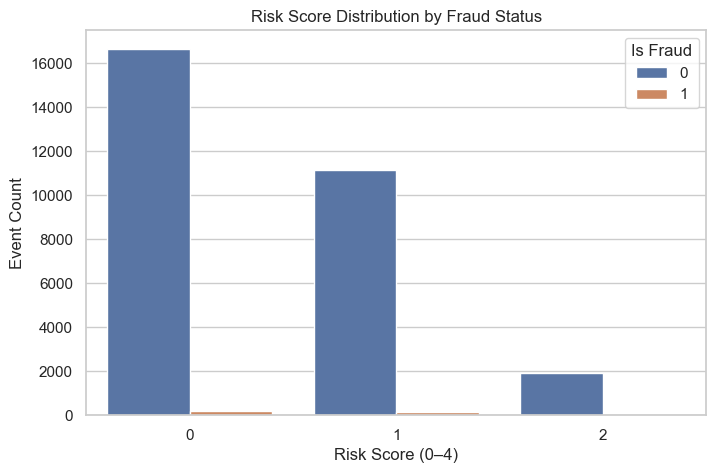

In [34]:
# Plot risk score distribution by fraud status
plt.figure(figsize=(8, 5))
sns.countplot(x='risk_score', hue='is_fraud', data=df)
plt.title("Risk Score Distribution by Fraud Status")
plt.xlabel("Risk Score (0–4)")
plt.ylabel("Event Count")
plt.legend(title="Is Fraud")
plt.show()


In [38]:
# Evaluate rule performance
# Assume: Rule flags any transaction with risk_score >= 2 as fraud
df['rule_prediction'] = (df['risk_score'] >= 2).astype(int)

from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report (Rule-Based Detection):")
print(classification_report(df['is_fraud'], df['rule_prediction'], target_names=["Legit", "Fraud"]))

print("Confusion Matrix:")
print(confusion_matrix(df['is_fraud'], df['rule_prediction']))


Classification Report (Rule-Based Detection):
              precision    recall  f1-score   support

       Legit       0.99      0.94      0.96     29707
       Fraud       0.01      0.04      0.01       359

    accuracy                           0.93     30066
   macro avg       0.50      0.49      0.49     30066
weighted avg       0.98      0.93      0.95     30066

Confusion Matrix:
[[27796  1911]
 [  343    16]]


#### Rule-Based Fraud Detection: Summary & Insights
Classification Report
- Precision (Fraud): 0.01 — Only 1% of transactions flagged as fraud were truly fraudulent.
- Recall (Fraud): 0.04 — Only 4% of actual fraud cases were correctly identified.
- F1-Score (Fraud): 0.01 — Indicates weak balance between precision and recall.
- Accuracy: 93% — Largely influenced by correct prediction of non-fraud cases.

In [ ]:
### Comparison: Rule-Based Model vs. Random Undersampling + Random Forest

This section compares the performance of two fraud detection approaches: a basic rule-based model and a machine learning model using random undersampling with Random Forest.

#### 1. Performance Metrics

| Metric              | Rule-Based Model        | Undersampling + Random Forest |
|---------------------|-------------------------|-------------------------------|
| Fraud Recall        | 0.06                    | 0.25                          |
| Fraud Precision     | 0.02                    | 0.39                          |
| Fraud F1-Score      | 0.01                    | 0.31                          |
| Accuracy            | 0.93                    | 0.77                          |
| ROC-AUC Score       | Not calculated          | 0.63                          |

- The Random Forest model detects six times more frauds than the rule-based system.
- It also achieves much higher precision, meaning fewer false positives.

#### 4. Conclusion

The rule-based system is overly conservative and fails to detect meaningful fraud patterns. The Random Forest model with random undersampling achieves a much better balance, identifying more fraud cases while keeping false positives relatively low. This makes it a more practical and effective solution for real-world fraud detection tasks.
